In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class DataManager:
    def __init__(self):
        self.feature = None
        self.rdf = None # raw df
        self.data = None # dictionary of processed dfs data
        self.X = None
        self.y = None
        self.tdata = None
        
    def read_training_data(self, file_name):
        df = pd.read_csv(file_name, encoding='big5', na_values=['NR'])
        df = df.fillna(0.0)
        df = df.rename(columns={
            df.columns[0]: 'date',
            df.columns[1]: 'location',
            df.columns[2]: 'feature'
        })
        df.date = pd.to_datetime(df.date)
        df = df.drop(columns=['location'])
        self.feature = sorted(df.feature.unique())
        self.rdf = df
        self.rdf_to_data()
        return 
    
    def preprocess_mdfs(self, mdfs):
        for m, df in mdfs.items():
#             nrows, ncols = df. shape
            cols = df.columns
#             mask = np.zeros((nrows, 1), dtype=bool)
            for col in cols:
                df = df[df[col] > 0.0]
#                 print(df)
            
            mdfs[m] = df
            
        return mdfs
    
    def rdf_to_data(self):
        rdf = self.rdf
        data = {month: {feature: df.drop(columns=['date', 'feature']).values.flatten() for feature, df in mdf.groupby(mdf.feature)} for month, mdf in rdf.groupby(rdf.date.dt.month)}
        self.data = data
        return 
    
    def select_feature_to_mdfs(self, feature_list=None):
        if feature_list is None:
            feature_list = self.feature
#         mdfs = {month: pd.DataFrame(columns=feature_list) for month in range(1, 13)}
        mdfs = {month: pd.DataFrame(columns=sorted(feature_list)) for month in range(1, 13)}

        for month, fdata in self.data.items():
            for feature in feature_list:
                mdfs[month][feature] = fdata[feature]
            
        return mdfs
    
    
    def chunk_examples(self, mdfs, chunk_size):
        X = []
        y = []
        for month, mdf in mdfs.items():
            nrows, ncols = mdf.shape

            for i in range(nrows-chunk_size):
#                 X.append(mdf.iloc[i:i+chunk_size].T.values.flatten())
#                 print(mdf)
                X.append(mdf.iloc[i:i+chunk_size].values.flatten())
                y.append(mdf['PM2.5'].iloc[i+chunk_size])
#                 print(mdf.iloc[i:i+chunk_size], mdf['PM2.5'].iloc[i+chunk_size])
                
        self.X = np.array(X)
        self.y = np.array(y).reshape((-1, 1))
        return self.X, self.y
    
    def get_shuffle_index(self):
        m, n = self.X.shape
        idx = np.random.permutation(np.arange(m))
        return idx
    
    def read_testing_data(self, file_name):
        df = pd.read_csv(file_name, header=None, na_values=['NR'])
        df = df.rename(columns={0: 'id', 1: 'feature'})
        df = df.fillna(0.0)
        self.tdata = df
        return
    
    def select_testing_feature(self, feature_list=None):
        if feature_list is None:
            feature_list = self.feature
            
        iddfs = {i: df for i, df in self.tdata.groupby(self.tdata.id)}
        
        for i, df in iddfs.items():
            columns = df.feature
            df = df.drop(columns=['id', 'feature']).T
            df.columns = columns
            df = df[sorted(feature_list)]
            iddfs[i] = df
        return iddfs


In [3]:
def normalize_data(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_n = (X - mu) / sigma
    return X_n, mu, sigma

In [4]:
def norm_eq(X, y):
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)
    return theta

In [5]:
def predict(theta, instance):
    h_theta = np.dot(instance, theta)
    return h_theta

In [6]:
def h(X, theta):
    return np.dot(X, theta)

In [7]:
def J(theta, h, X, y):
    m, n = X.shape
    square_error = np.sum((h(X, theta) - y)**2)
    return (1 / 2) * (1 / m) * square_error

In [8]:
def gradient_descent(theta, h, X, y, eta, n_iters):
    m, n = X.shape
    theta_record = np.zeros((n_iters, *theta.shape))
    loss_record = np.zeros((n_iters, 1))
    
    theta_record[0] = theta
    loss_record[0] = J(theta, h, X, y)
    grad_square_sum = np.zeros(theta.shape)
    for i in range(1, n_iters):
        grad = (1 / m) * np.dot(X.T, (h(X, theta) - y))
        
        grad_square_sum = grad**2 + grad_square_sum
        
        theta = theta - eta * grad / np.sqrt(grad_square_sum)
        theta_record[i] = theta
        loss_record[i] = J(theta, h, X, y)
        
    return theta, theta_record, loss_record

In [9]:
def initialize_theta(X):
    m, n = X.shape
    
    return np.random.normal(loc=0, scale=1, size=(n, 1))

In [10]:
def find_example_error(theta, h, J, X, y):
    error_list = []

    for i, example in enumerate(zip(X, y)):
        xx, yy = example
        xx = xx.reshape((1, -1))
        yy = yy.reshape((1, 1))
        error_list.append((J(theta, h, xx, yy), i, xx, yy))

    return error_list

In [11]:
def validate_data(rate, h, J, X, y):
    print(X.shape)
    norm_theta = norm_eq(X, y)
    error_list = sorted(find_example_error(norm_theta, h, J, X, y), reverse=True)
    to_drop = error_list[0:int(rate*len(error_list))]
    to_drop_idx = [idx for err, idx, xx, yy in to_drop]
    print(error_list[0:3], error_list[100:103])
    return np.delete(X, to_drop_idx, axis=0), np.delete(y, to_drop_idx, axis=0)

In [12]:
def remove_non_positive_data(X, y):
    Xmask = np.all(X > 0, axis=1)
    ymask = np.all(y > 0, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

In [13]:
def remove_strange_data(X, y):
    Xmask = np.all(X < 300, axis=1)
    ymask = np.all(y < 300, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

In [14]:
dm = DataManager()

In [15]:
dm.read_training_data('./train.csv')

In [16]:
# mdfs = dm.select_feature_to_mdfs(['PM2.5', 'PM10'])
mdfs = dm.select_feature_to_mdfs(['PM2.5'])

In [17]:
# mdfs = dm.preprocess_mdfs(mdfs)
mdfs[1].shape

(480, 1)

In [18]:
X, y = dm.chunk_examples(mdfs, chunk_size=4)

In [19]:
X, y = remove_non_positive_data(X, y)
X.shape

(5392, 4)

In [20]:
X, y = remove_strange_data(X, y)
X.shape

(5385, 4)

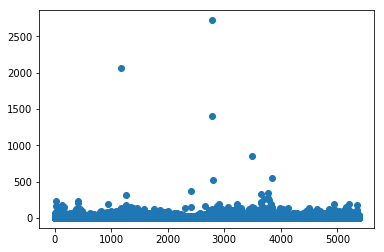

In [21]:
errlist = find_example_error(norm_eq(X, y), h, J, X, y)
fig, ax = plt.subplots()
ax.scatter(np.arange(len(errlist)), [j for j,_,_,_ in errlist])

In [22]:
for i in errlist:
    if i[0] > 500:
        print(i)

(2067.8524420132107, 1167, array([[ 61.,  66.,  66.,  69.]]), array([[ 131.]]))
(2721.5124299027439, 2787, array([[ 41.,  23.,  23.,  30.]]), array([[ 111.]]))
(1405.4274826994535, 2790, array([[  30.,  111.,  115.,  118.]]), array([[ 35.]]))
(523.01148952326184, 2793, array([[ 118.,   35.,   32.,   33.]]), array([[ 30.]]))
(857.03322075002848, 3489, array([[ 94.,  42.,  48.,  44.]]), array([[ 21.]]))
(554.07124572212967, 3838, array([[ 41.,  62.,  64.,  54.]]), array([[ 11.]]))


In [23]:
X_n, mu, sigma = normalize_data(X)
X_n = np.insert(X_n, obj=0, values=1, axis=1)

In [24]:
X[np.any(X <=0, axis=1)][:3]
X_n.shape[0] * 0.001

5.385

In [25]:
X_n, y = validate_data(0.001, h, J, X_n, y)
# X_n, y = validate_data(0.001, h, J, X_n, y)
X_n.shape

(5385, 5)
[(2720.9801000865587, 2787, array([[ 1.        ,  0.70453258, -0.26919354, -0.26818548,  0.11371528]]), array([[ 111.]])), (2123.9686933720614, 1167, array([[ 1.        ,  1.7876707 ,  2.06337052,  2.06463526,  2.23297297]]), array([[ 131.]])), (1360.1073751742126, 2790, array([[ 1.        ,  0.10880661,  4.50442592,  4.72296587,  4.89563006]]), array([[ 35.]]))] [(94.762403560492984, 1299, array([[ 1.        ,  1.02947401,  1.19543971,  2.01038362,  2.12429309]]), array([[ 53.]])), (91.795948810799686, 816, array([[ 1.        ,  0.10880661,  0.38175457, -0.10543054,  0.11371528]]), array([[ 41.]])), (91.778427700259343, 5348, array([[ 1.        ,  0.86700329,  1.84638781,  2.33589349,  2.50467267]]), array([[ 54.]]))]


(5380, 5)

In [26]:
norm_theta = norm_eq(X_n, y)

In [27]:
dm.read_testing_data('./test.csv')

In [29]:
# tX = dm.select_testing_feature(['PM2.5', 'PM10'])
tX = dm.select_testing_feature(['PM2.5'])
tX['id_87']#.iloc[-5:, :]


feature,PM2.5
2,73.0
3,88.0
4,92.0
5,89.0
6,86.0
7,80.0
8,93.0
9,91.0
10,95.0


In [30]:
init_theta = initialize_theta(X_n)
print(init_theta.shape)
theta, theta_record, loss_record = gradient_descent(init_theta, h, X_n, y, eta=0.1, n_iters=200000)
loss_record[-1]

(5, 1)


array([ 13.94847018])

In [31]:
results = []
for i, tdf in tX.items():
    tdf = tdf.iloc[-4:, :]
    instance_n = (tdf.values.flatten() - mu) / sigma
#     instance_n = (tdf.T.values.flatten() - mu) / sigma

#     print(tdf.T.values.flatten())
    results.append((i, predict(norm_theta, np.insert(instance_n.reshape((1, -1)), obj=0, values=1, axis=1))[0, 0]))
results = np.array(results)

In [32]:
theta

array([[ 27.87146785],
       [  5.77890489],
       [ -8.79687489],
       [  0.37582668],
       [ 20.16081798]])

In [33]:
norm_theta

array([[ 27.87193825],
       [  5.94834234],
       [ -8.81978775],
       [ -0.17870635],
       [ 20.59464364]])

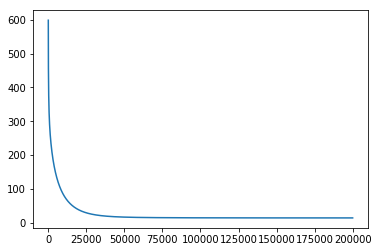

In [34]:
fig, ax = plt.subplots()
ax.plot(np.arange(loss_record.size), loss_record)
# len(loss_record)

In [35]:
J(theta, h, X_n, y)

13.948470182556045

In [36]:
J(norm_theta, h, X_n, y)

13.937634270098822

In [37]:
pd.DataFrame(results, columns=['id', 'value']).to_csv('qq.csv', index=False)

In [38]:
pd.DataFrame(results, columns=['id', 'value'])

,id,value
0,id_0,39.172921412
1,id_1,13.8352702002
2,id_10,24.7370350586
3,id_100,21.7670386954
4,id_101,47.0883735583
5,id_102,31.4087123148
6,id_103,33.0513219307
7,id_104,34.1614102709
8,id_105,30.481528267
9,id_106,16.9212358977
